

### 🧠 Quick sanity check logic

Here’s what indirectly checking:

| Step | Logic |
|------|-------|
| 1 | Are grid polygons correctly formed from MERRA-2 lat/lon → UTM? |
| 2 | Are particles generated from those polygons (`pointpats.random.poisson`)? |
| 3 | Are particles back-projected correctly to lat/lon? |
| 4 | Are particles logically grouped by observation grid cell (and visible on map)? |

This notebook I fixed the sensor to have a start and end time instead of spatial averaging and dt

In [2]:
from advectionGP.sensors import FixedSensorModel, RemoteSensingModel
import numpy as np
sensors = RemoteSensingModel()

obsLocs = []
t_start, t_end = 1260, 1440  # last 3 hours in minutes

for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start, t_end, x, y])

obsLocs = np.array(obsLocs)
particles = sensors.genParticles(Nparticles=10)


In [3]:
print(particles.shape)


(10, 50, 3)


In [ ]:
print("Example for one observation:")
print(particles[:, 0, :])  # 10 particles for the 1st obs


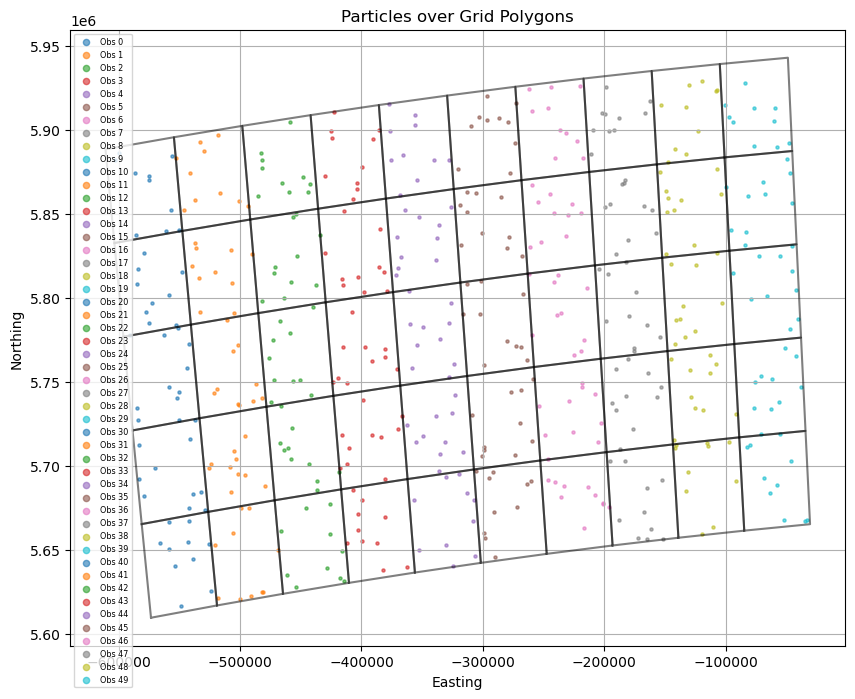

In [4]:
from shapely.geometry import mapping
import matplotlib.pyplot as plt
num_particles, num_observations, _ = particles.shape

plt.figure(figsize=(10, 8))
for polygon in sensors.grid_polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y, 'k-', alpha=0.5)

for obs in range(num_observations):
    x = particles[:, obs, 1]
    y = particles[:, obs, 2]
    plt.scatter(x, y, s=5, alpha=0.6, label=f"Obs {obs}")

plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("Particles over Grid Polygons")
plt.legend(markerscale=2, fontsize='xx-small')
plt.grid(True)
plt.show()


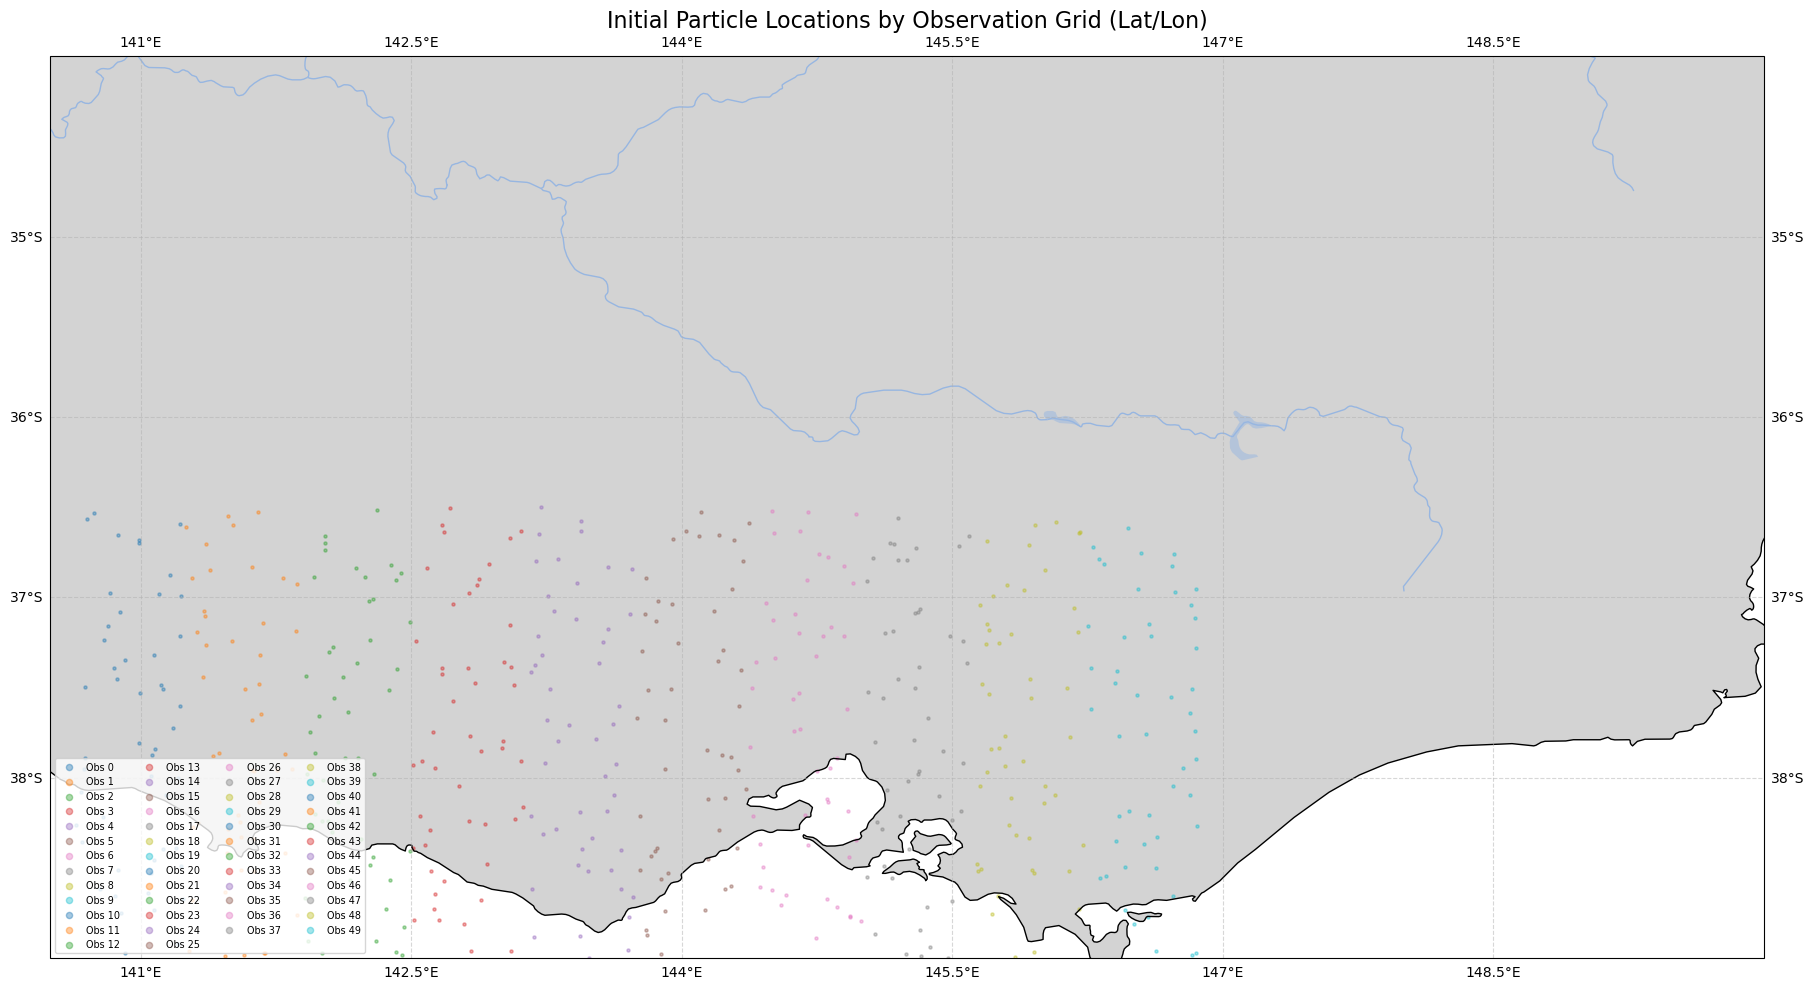

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer

# Create transformer from UTM Zone 56S (EPSG:32756) to WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)

# Set up map
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140.5, 150, -39, -34], crs=ccrs.PlateCarree())  # Victoria region

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# Plot particles
num_particles, num_observations, _ = particles.shape
for obs in range(num_observations):
    east = particles[:, obs, 1]
    north = particles[:, obs, 2]
    lon, lat = transformer.transform(east, north)  # Convert to lat/lon

    ax.scatter(lon, lat, s=5, alpha=0.4, transform=ccrs.PlateCarree(), label=f"Obs {obs}")

# Optional legend to avoid clutter
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize="x-small", markerscale=2, loc="lower left", ncol=4)

plt.title("Initial Particle Locations by Observation Grid (Lat/Lon)", fontsize=16)
plt.tight_layout()
plt.show()


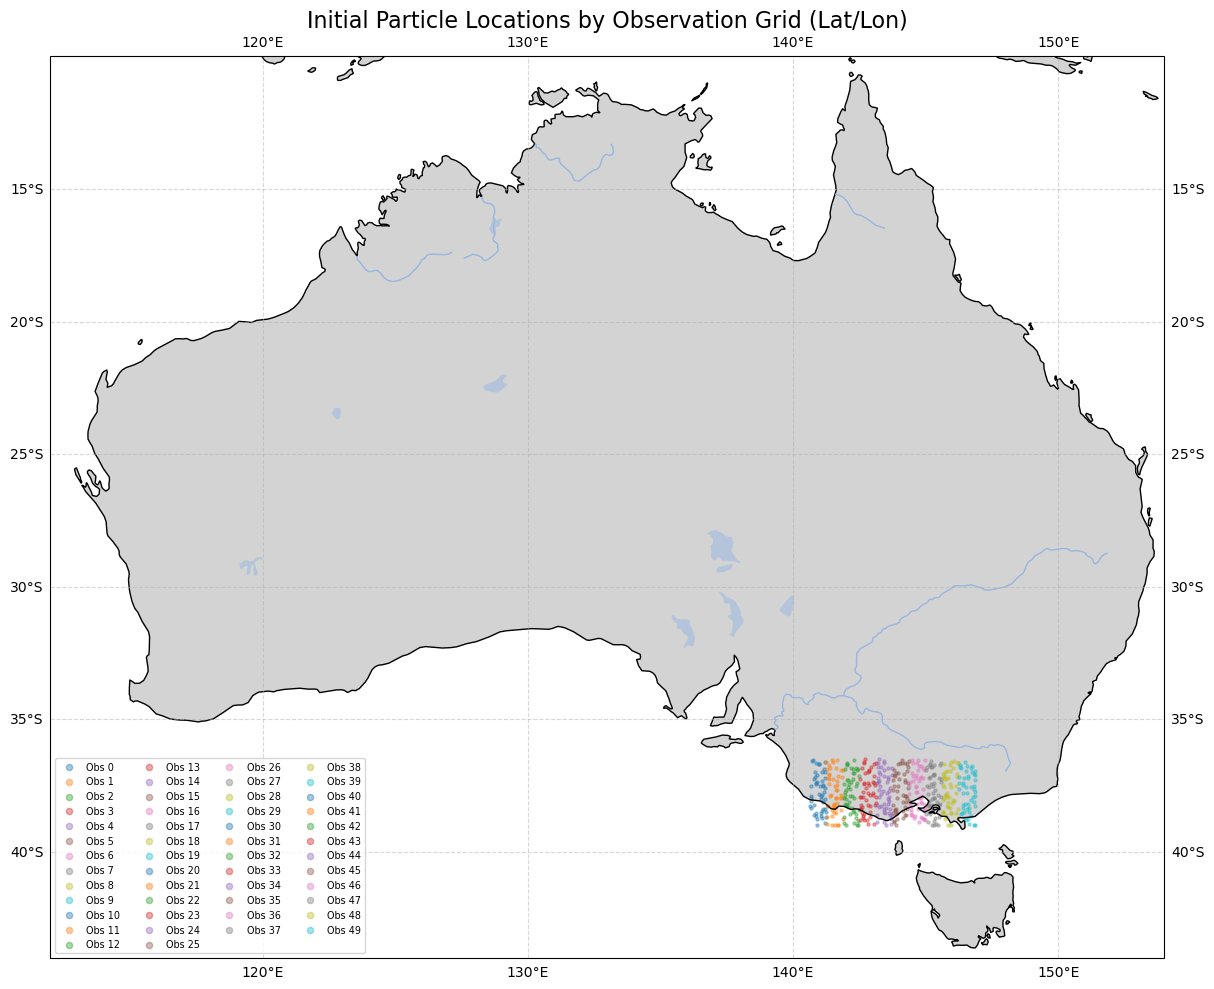

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer

# Create transformer from UTM Zone 56S (EPSG:32756) to WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)

# Set up map
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())  # Victoria region

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# Plot particles
num_particles, num_observations, _ = particles.shape
for obs in range(num_observations):
    east = particles[:, obs, 1]
    north = particles[:, obs, 2]
    lon, lat = transformer.transform(east, north)  # Convert to lat/lon

    ax.scatter(lon, lat, s=5, alpha=0.4, transform=ccrs.PlateCarree(), label=f"Obs {obs}")

# Optional legend to avoid clutter
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize="x-small", markerscale=2, loc="lower left", ncol=4)

plt.title("Initial Particle Locations by Observation Grid (Lat/Lon)", fontsize=16)
plt.tight_layout()
plt.show()


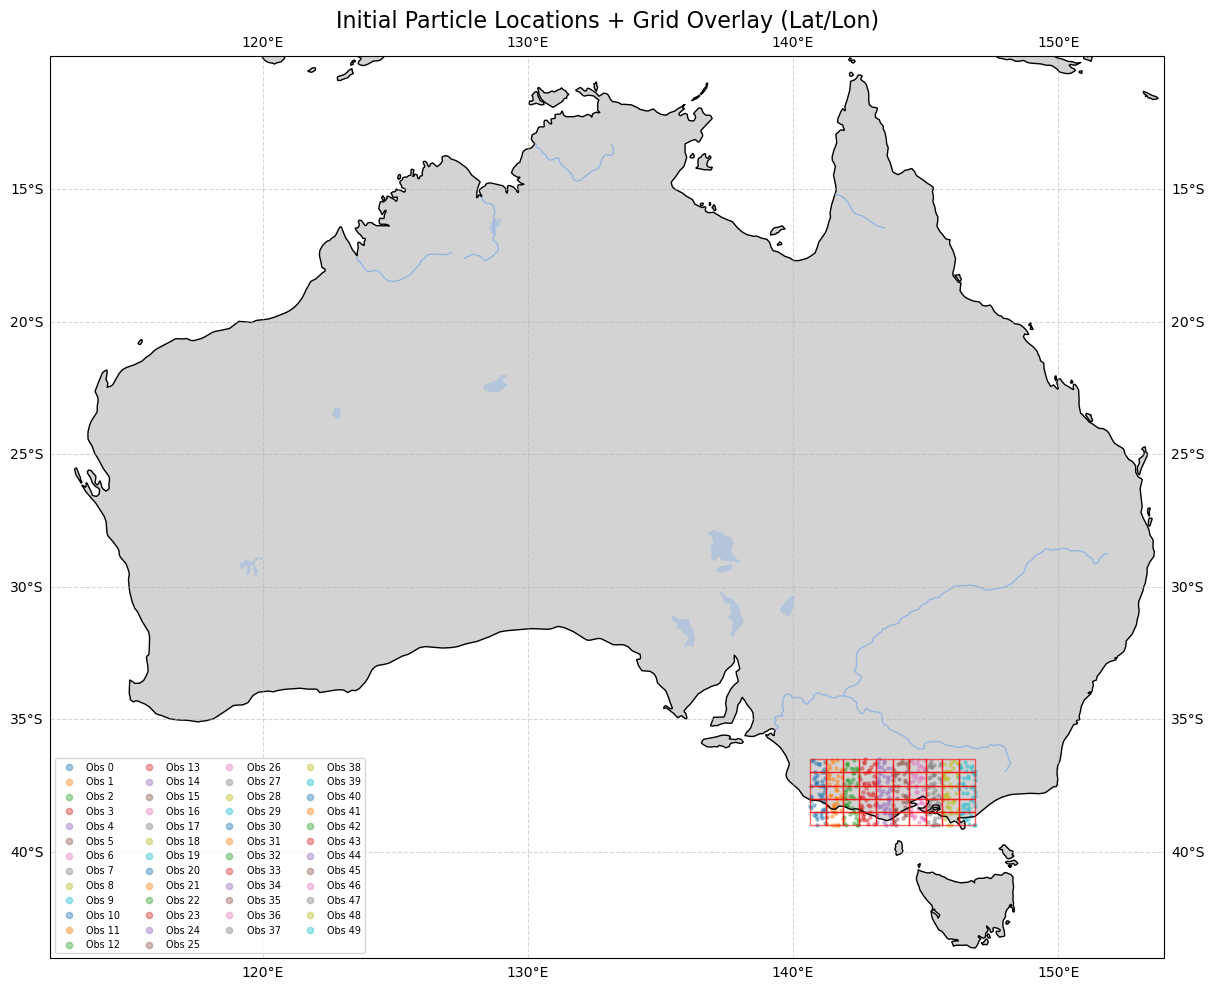

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer
import numpy as np

# Transformer: UTM Zone 56S to WGS84 (EPSG:32756 ➝ EPSG:4326)
transformer = Transformer.from_crs("EPSG:32756", "EPSG:4326", always_xy=True)

# Set up map
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())  # Whole Australia

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# === Plot grid polygons from sensors.grid_polygons ===
for polygon in sensors.grid_polygons:
    x, y = polygon.exterior.coords.xy
    lon, lat = transformer.transform(np.array(x), np.array(y))
    ax.plot(lon, lat, color='red', linewidth=1.0, alpha=0.6, transform=ccrs.PlateCarree())

# === Plot particles ===
num_particles, num_observations, _ = particles.shape
for obs in range(num_observations):
    east = particles[:, obs, 1]
    north = particles[:, obs, 2]
    lon, lat = transformer.transform(east, north)  # Convert to lat/lon
    ax.scatter(lon, lat, s=5, alpha=0.4, transform=ccrs.PlateCarree(), label=f"Obs {obs}")

# Clean legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize="x-small", markerscale=2, loc="lower left", ncol=4)

plt.title("Initial Particle Locations + Grid Overlay (Lat/Lon)", fontsize=16)
plt.tight_layout()
plt.show()
